In [9]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.gridspec as gridspec
import seabornfig2grid as sfg


from scipy.stats import percentileofscore
from scipy import stats

import pymc3 as pm
import arviz as az

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import scipy.stats as scs
from scipy.stats import norm
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

### Business Idea: How Much Each Channel contribute to the Target?

#### Loading Data

In [3]:
data = pd.read_excel('data/bet_awards_modfile_FINAL_08.23.2021.xlsx')
data.head()

,dma_code,cplx_imp_i,smsn_imp_i,spot_imp_i,vzio_imp_i,tw_imp_i,fb_imp_i,yt_imp_i,tv_exp_i,tune_in_i
0,500.0,0.008422,0.015025,0.212211,0.013772,0.348791,0.023189,0.119566,0.005713,0.050437
1,501.0,0.016431,0.036270,0.225445,0.007491,0.369489,0.046153,0.184742,0.010343,0.097058
2,502.0,0.006553,0.015509,0.178028,0.011686,0.344432,0.037104,0.141722,0.008395,0.132308
3,503.0,0.010626,0.017485,0.119478,0.013206,0.353738,0.095669,0.236077,0.022665,0.223991
4,504.0,0.016560,0.025442,0.204707,0.010759,0.370823,0.046618,0.321395,0.015143,0.130586


In [4]:
# dma_code column assigned to region and can be dropped
data = data.drop(columns=['dma_code'])
# checking for Nan values in columns
data.isna().sum().sum()

0

In [5]:
data.describe()

,cplx_imp_i,smsn_imp_i,spot_imp_i,vzio_imp_i,tw_imp_i,fb_imp_i,yt_imp_i,tv_exp_i,tune_in_i
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,0.008516,0.021490,0.180836,0.013638,0.352482,0.050132,0.175388,0.010169,0.091919
std,0.003937,0.008625,0.052792,0.009866,0.010691,0.018990,0.059557,0.004788,0.054194
min,0.001626,0.008018,0.074963,0.007491,0.334246,0.000000,0.071617,0.001961,0.000000
25%,0.005782,0.015603,0.147842,0.011492,0.344670,0.037052,0.138629,0.006756,0.056087
50%,0.007491,0.020142,0.172508,0.012958,0.350286,0.046479,0.161186,0.009065,0.083639
75%,0.010398,0.025903,0.211144,0.014160,0.357436,0.057383,0.195522,0.011949,0.119984
max,0.022324,0.058665,0.368853,0.150939,0.401953,0.139827,0.434015,0.024520,0.250879


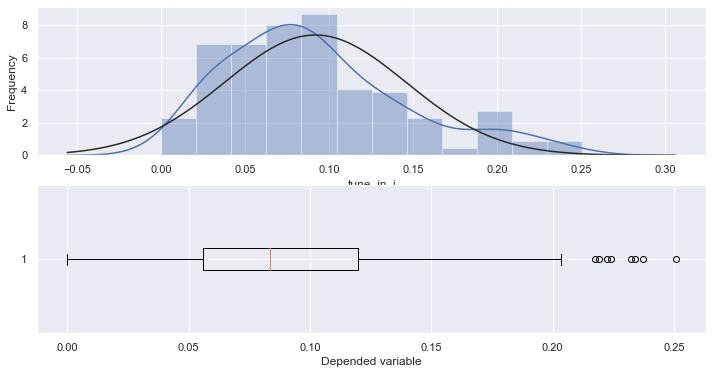

In [6]:
# Distribution of the target variable
target_distribution(data.tune_in_i)

#### As we can tell Target variable is aproximatly Normally Distributed with mean = 0.09 and median = 0.08. As mean < median we observe right skewness

### Relationship between independent and dependent variable

### Check for Multicolinearity between independent variables

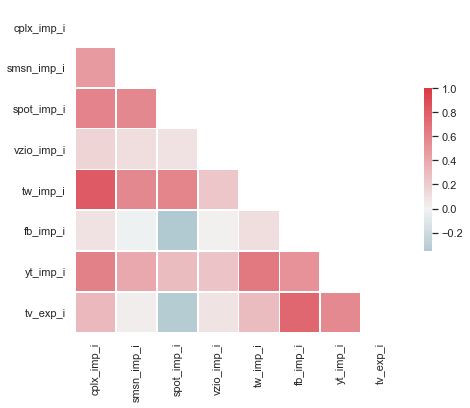

Based on threshold 0.8 , sugested featrures to drop - ['cplx_imp_i', 'tw_imp_i']


,cplx_imp_i,tw_imp_i
cplx_imp_i,1.000000,0.812304
tw_imp_i,0.812304,1.000000


In [7]:
features_corr_matrix(data.iloc[:,:-1], 0.8, matrix= True)

Multicollinearity will certainty effect the inference we make.

However, unlike in frequentist settings, the sampling process will not blow up. Instead, the ambiguity inherent in estimating coefficients of collinear predictors will show up as dependence in the posterior.

Estimation goes just fine, but there’s lots of ambiguity about the values of these parameters (as there should be).

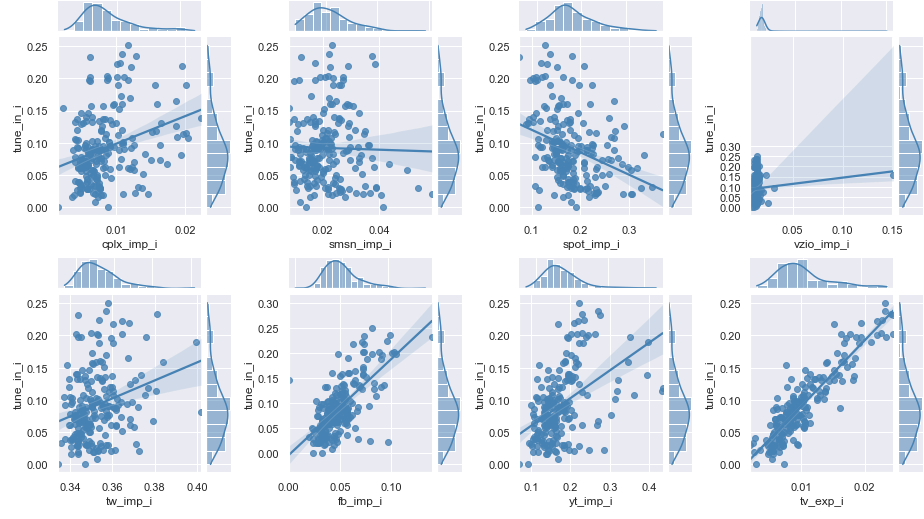

In [10]:
plot_relationship(data, 'tune_in_i')

In [21]:
#plot_relationship(data.iloc[:,:-1], data.tune_in_i)

## Building Multiple Bayesian Linear Model with pyMC3

In [59]:
x = data.iloc[:,:-1].values
y = data.tune_in_i.values

In [60]:
with pm.Model() as model_mlr_normal:
    
    # Intercept
    alpha = pm.Normal('alpha', mu=0, sd=25)
    # Slope
    beta = pm.Normal('beta', mu=0, sd=25, shape= len(data.columns[:-1]))
    # Error term
    eps = pm.HalfCauchy('eps', 25)
    # Expected value of outcome (MLR with vectors)
    mu =  alpha + pm.math.dot(x, beta)
    # Likelihood
    tune_in_i = pm.Normal('tune_in_i', mu= mu, sd= eps, observed= y)
    
    # posterior/create the race
    trace_mlr_normal = pm.sample(chains= 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 264 seconds.


### Check Posterior

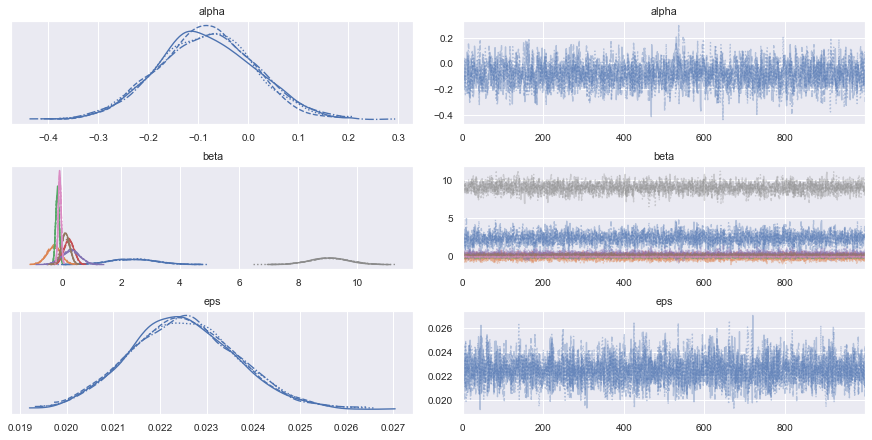

In [61]:
az.plot_trace(trace_mlr_normal)
plt.show()

In [62]:
varnames = trace_mlr_normal.varnames
varnames

['alpha', 'beta', 'eps_log__', 'eps']

In [63]:
# Lets look at intercepts
az.summary(trace_mlr_normal, var_names = ['beta']).set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cplx_imp_i,2.378,0.775,0.904,3.816,0.015,0.010,2755.0,2742.0,1.0
smsn_imp_i,-0.280,0.238,-0.739,0.156,0.004,0.003,4040.0,2862.0,1.0
spot_imp_i,-0.156,0.058,-0.264,-0.047,0.001,0.001,2855.0,3063.0,1.0
vzio_imp_i,0.230,0.168,-0.088,0.536,0.003,0.002,4486.0,2849.0,1.0
tw_imp_i,0.293,0.297,-0.268,0.824,0.006,0.005,2149.0,2284.0,1.0
fb_imp_i,0.118,0.142,-0.153,0.374,0.003,0.002,2906.0,2364.0,1.0
yt_imp_i,-0.080,0.047,-0.167,0.010,0.001,0.001,3073.0,3078.0,1.0
tv_exp_i,9.052,0.648,7.854,10.260,0.013,0.009,2520.0,2401.0,1.0


In [66]:
# Lets look at the slope and error
az.summary(trace_mlr_normal, var_names = ['alpha','eps'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.084,0.096,-0.258,0.098,0.002,0.001,2106.0,2265.0,1.0
eps,0.023,0.001,0.020,0.025,0.000,0.000,4109.0,2427.0,1.0


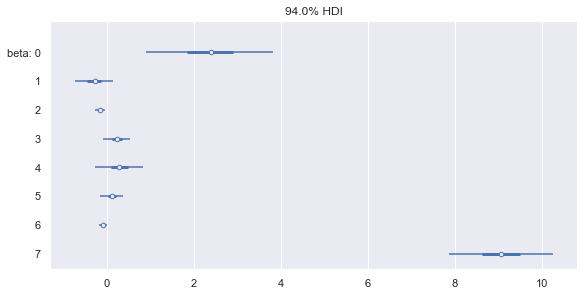

In [89]:
az.plot_forest(trace_mlr_normal, var_names=['beta'], combined=True, colors='cycle',  figsize=(8,4))
plt.show()

Multiple linear regression model reacts to redundant variables, there is importance of considering possible confounding variables.

The HPD for  coefficients is suspiciously wide. We can get a clue to what is going on with a scatter plot of the  coefficients:

In [11]:
cplx_imp_i = pd.DataFrame(trace_mlr_normal['beta'], columns=data.columns[:-1])['cplx_imp_i']
tv_exp_i = pd.DataFrame(trace_mlr_normal['beta'], columns=data.columns[:-1])['tv_exp_i']
sns.jointplot(x= cplx_imp_i, y= tv_exp_i, kind="scatter", color='steelblue', height=5)
plt.show()

NameError: name 'trace_mlr_normal' is not defined

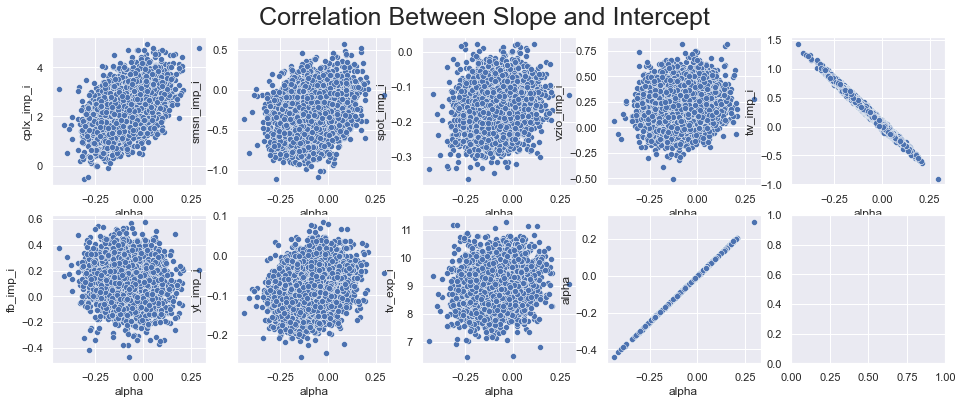

In [125]:
plot_correlation(trace_mlr_normal, data)

The following parameters have an Rhat greater 1.005:


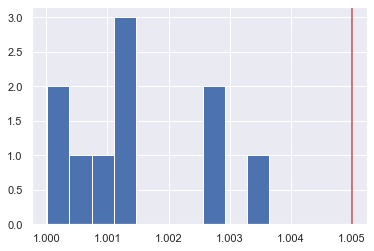

In [129]:
check_rhat(trace_mlr_normal, 1.005) # We should be consern if there is Rhat more then 0.1 !!!

In [98]:
# az.plot_pair(trace_normal, kind ='kde', fill_last= False)

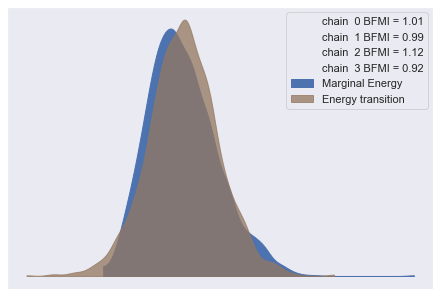

In [130]:
az.plot_energy(trace_mlr_normal)
plt.show()

### Posterior Predictions Check

In [131]:
## Look for predictions using posterior
ppc__mlr_normal = pm.sample_posterior_predictive(trace_normal, samples=100, model = model_mlr_normal)

In [132]:
az.r2_score(y, ppc_normal['tune_in_i'])

r2        0.828459
r2_std    0.021827
dtype: float64

In [133]:
results_normal = pd.DataFrame(ppc_normal['tune_in_i']).T
results_normal.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.053689,0.053386,0.049323,0.079835,0.010744,0.009851,0.045967,0.072612,0.059199,0.014073,...,0.017470,0.073928,0.061734,0.055120,0.062953,0.071861,0.006981,0.090113,0.030376,0.028495
1,0.106849,0.068210,0.135164,0.090371,0.120945,0.050951,0.079820,0.123539,0.113587,0.061151,...,0.068405,0.054899,0.124883,0.139244,0.064967,0.098784,0.087953,0.100923,0.106765,0.035372
2,0.060710,0.061229,0.088942,0.063899,0.060295,0.090506,0.061654,0.079066,0.056988,0.075102,...,0.106114,0.067313,0.092273,0.042227,0.015221,0.069140,0.045081,0.096294,0.031039,0.100706
3,0.201626,0.238496,0.204312,0.266523,0.228155,0.242895,0.237537,0.213327,0.160820,0.247766,...,0.229931,0.233077,0.182555,0.241069,0.185387,0.251699,0.198671,0.223798,0.222109,0.222254
4,0.133724,0.146463,0.098349,0.125241,0.116907,0.119205,0.152147,0.143825,0.122477,0.122485,...,0.159479,0.091270,0.139326,0.197645,0.207269,0.176753,0.168350,0.158374,0.136812,0.083829


posterior predictive variable tune_in_i's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


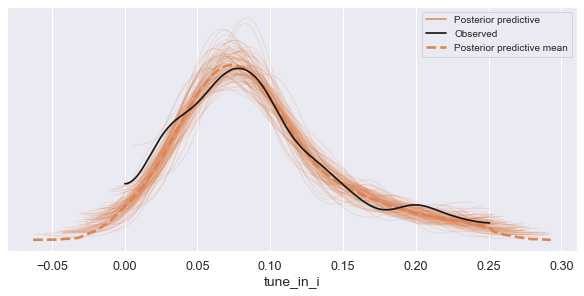

In [196]:
data_ppc = az.from_pymc3(trace= trace_mlr_normal, posterior_predictive= ppc__mlr_normal)
ax = az.plot_ppc(data_ppc, figsize=(8,4), mean= True, color='C1',)
ax.legend(fontsize= 10)
plt.show()

## Building Multiple Bayesian Linear Model with GLM

In [147]:
# Formula for Bayesian Linear Regression (follows R formula syntax
formula = 'tune_in_i ~ ' + ' + '.join(['%s' % variable for variable in data.columns[:-1]])
formula

'tune_in_i ~ cplx_imp_i + smsn_imp_i + spot_imp_i + vzio_imp_i + tw_imp_i + fb_imp_i + yt_imp_i + tv_exp_i'

In [173]:
# Context for the model
with pm.Model() as model_normal_glm:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    tune_in_i  = pm.GLM.from_formula(formula, data = data, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    trace_normal_glm = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, tv_exp_i, yt_imp_i, fb_imp_i, tw_imp_i, vzio_imp_i, spot_imp_i, smsn_imp_i, cplx_imp_i, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 279 seconds.


In [178]:
var_names_glm = trace_normal_glm.varnames
print(var_names_glm)

['Intercept', 'cplx_imp_i', 'smsn_imp_i', 'spot_imp_i', 'vzio_imp_i', 'tw_imp_i', 'fb_imp_i', 'yt_imp_i', 'tv_exp_i', 'sd_log__', 'sd']


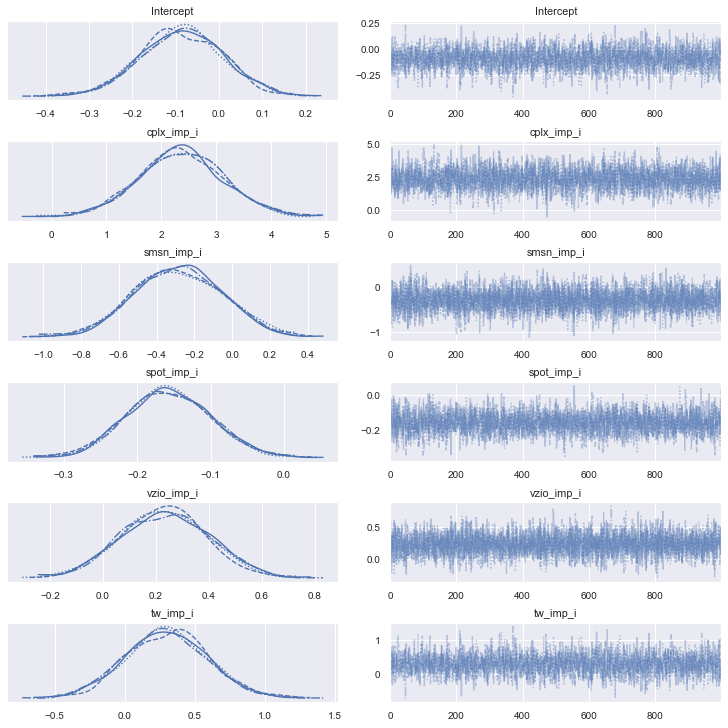

In [179]:
az.plot_trace(trace_normal_glm, figsize= (10,10), var_names = var_names_glm[:-5], )
plt.show()

In [180]:
az.summary(trace_normal_glm, var_names = var_names_glm[1:-2]).set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cplx_imp_i,2.363,0.774,0.907,3.855,0.015,0.010,2727.0,2508.0,1.0
smsn_imp_i,-0.285,0.235,-0.713,0.153,0.004,0.003,3849.0,2793.0,1.0
spot_imp_i,-0.157,0.058,-0.266,-0.052,0.001,0.001,3009.0,2633.0,1.0
vzio_imp_i,0.232,0.165,-0.075,0.540,0.003,0.002,4098.0,3035.0,1.0
tw_imp_i,0.301,0.295,-0.242,0.859,0.007,0.005,2056.0,2024.0,1.0
fb_imp_i,0.118,0.140,-0.135,0.386,0.003,0.002,3023.0,2658.0,1.0
yt_imp_i,-0.080,0.046,-0.166,0.006,0.001,0.001,3217.0,2651.0,1.0
tv_exp_i,9.052,0.642,7.872,10.274,0.012,0.009,2811.0,2944.0,1.0


In [181]:
# Lets look at the slope and error
az.summary(trace_normal_glm, var_names= var_names_glm[0])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.087,0.096,-0.263,0.095,0.002,0.002,1975.0,2217.0,1.0


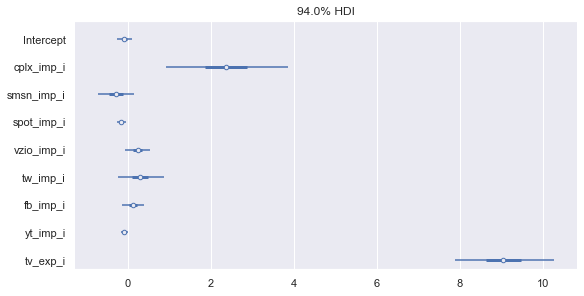

In [182]:
az.plot_forest(trace_normal_glm, var_names=var_names_glm[:-2], combined=True, colors='cycle',  figsize=(8,4))
plt.show()

### Posterior Predictions Check

In [183]:
## Look for predictions using posterior
ppc_normal_glm = pm.sample_posterior_predictive(trace_normal_glm, samples=100, model = model_normal_glm)

In [186]:
az.r2_score(y, ppc_normal_glm['y'])

r2        0.826972
r2_std    0.023024
dtype: float64

In [189]:
results_normal_glm = pd.DataFrame(ppc_normal_glm['y']).T
results_normal_glm.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.023165,0.039425,0.067987,0.048033,0.016948,0.043537,0.032990,0.052253,0.069983,0.093322,...,0.049068,0.043718,0.034018,-0.007699,0.015680,0.037649,0.037996,0.083666,0.050252,0.093375
1,0.066160,0.067044,0.064519,0.135057,0.089007,0.136695,0.116647,0.114669,0.076272,0.119736,...,0.101371,0.055268,0.127460,0.140925,0.122800,0.104405,0.058811,0.103296,0.111925,0.053485
2,0.087265,0.063826,0.064988,0.090145,0.087299,0.080212,0.062780,0.056456,0.076803,0.069507,...,0.075114,0.031381,0.051498,0.049570,0.073413,0.070123,0.050105,0.059511,0.093563,0.068453
3,0.188709,0.205058,0.192989,0.208315,0.218221,0.244871,0.237857,0.245471,0.239650,0.206712,...,0.193262,0.245480,0.256882,0.254950,0.227327,0.217063,0.216208,0.238180,0.205052,0.241664
4,0.121105,0.134508,0.165166,0.134055,0.137740,0.177887,0.151245,0.150949,0.173526,0.188216,...,0.099409,0.162767,0.135395,0.168579,0.154460,0.115361,0.105955,0.144971,0.152773,0.136384


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


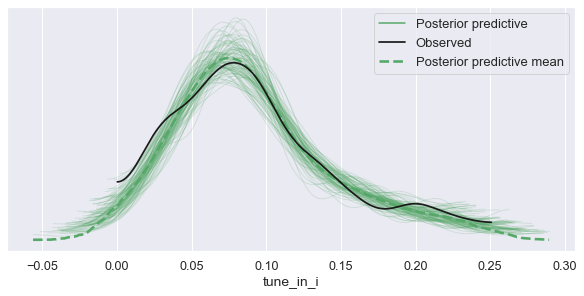

In [197]:
data_ppc_glm = az.from_pymc3(trace= trace_normal_glm, posterior_predictive= ppc_normal_glm)
ax = az.plot_ppc(data_ppc_glm, figsize=(8,4), mean= True, color='C2',)
ax.legend(fontsize= 13)
ax.set_xlabel('tune_in_i')
plt.show()

## Models Comparison

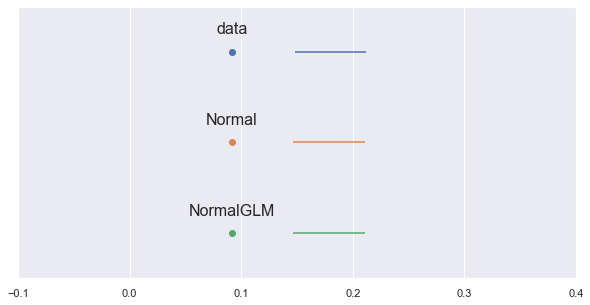

In [202]:
plt.figure(figsize=(10, 5))
ppc_data = [y, ppc_normal['tune_in_i'], ppc_normal_glm['y']]

labels = ['data', 'Normal', 'NormalGLM']
for i, d in enumerate(ppc_data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=16)
    plt.ylim([-i-0.5, 0.5])
    plt.xlim([-0.1, 0.4])
    plt.yticks([])

The preceding diagram shows the mean and the interquartile range (IQR) for the data(Blue), MLR_Normal(Orange) and GLM_Normal(Green). In this diagram, we are averaging over the posterior predictive samples for each model. We can see that the mean is (on average) well reproduced for both models, and that the interquantile range is in line with real data.

### Dispersion of both the mean and the interquartile range, as opposed to their mean values

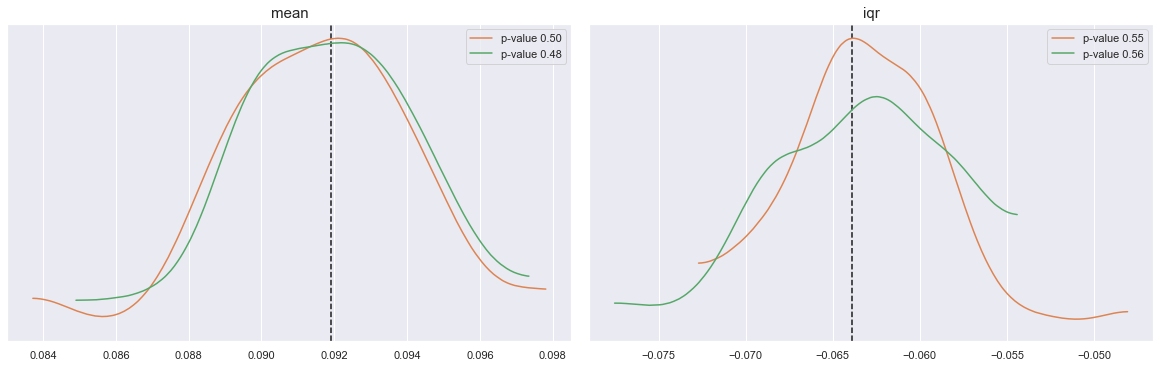

In [205]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

def iqr(k, a=0):
    # calculate range
    return np.subtract(*np.percentile(k, [25, 75], axis=a))


for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    
    for d_sim, c in zip([ppc__mlr_normal['tune_in_i'], 
                         ppc_normal_glm['y'],
                         ],
                        ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c},
        label=f'p-value {p_value:.2f}', ax=ax[idx])
        ax[idx].set_title(func.__name__, size =15)
        ax[idx].set_yticks([])
        ax[idx].legend()

Black dashed line represents the statistic computed from the data (either the mean or the IQR).The curves represent the distribution of the mean (left panel) or interquartile range (right panel) that was computed from the posterior predictive samples. You may have also noted that Figure 5.4 also includes values labeled as P-values. 


We compute such P-values by comparing the simulated data to the actual data.


For both sets, we compute a summary statistic (the mean or IQR, in this example), and then we count the proportion of times the summary statistics from the simulation is equal or greater than the one computed from the data.


If the data and simulation agrees, we should expect a P-value around 0.5, otherwise we are in the presence of a biased posterior predictive distribution.

## Dealing with Confounding variables and redundant variables

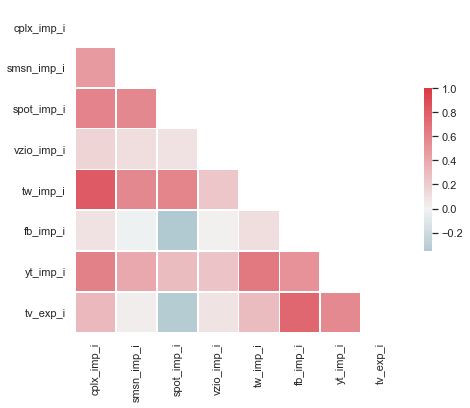

Based on threshold 0.8 , sugested featrures to drop - ['cplx_imp_i', 'tw_imp_i']


,cplx_imp_i,tw_imp_i
cplx_imp_i,1.000000,0.812304
tw_imp_i,0.812304,1.000000


In [18]:
features_corr_matrix(data.iloc[:,:-1], 0.8, matrix= True)

#### Building 3 different GLM models. m1_cpix_imp_i_tw_imp_i will have all the features, m2__cpix_imp_i will have one of the corr feature excluded and m3_tw_imp_i will have second of corr feature excluded 

In [81]:
data_cplx_imp_i = data[[col for col in data.columns if col != 'tw_imp_i']]
data_tw_imp_i = data[[col for col in data.columns if col != 'cplx_imp_i']]

# naming each df
data.name = 'data'
data_cplx_imp_i.name = 'data_cplx_imp_i'
data_tw_imp_i.name = 'data_tw_imp_i'

In [82]:
data_sets = [data, data_cplx_imp_i, data_tw_imp_i]

In [83]:
indiv_traces= {}

for df in data_sets:
    # build the formula based on a features from data set
    formula = 'tune_in_i ~ ' + ' + '.join(['%s' % variable for variable in df.columns[:-1]])
    # Context for the model
    with pm.Model() as individual_model:

        # The prior for the model parameters will be a normal distribution
        family = pm.glm.families.Normal()

        # Creating the model requires a formula and data (and optionally a family)
        tune_in_i= pm.GLM.from_formula(formula, data = df, family = family)

        # Perform Markov Chain Monte Carlo sampling
        trace = pm.sample(chains = 4, target_accept = 0.9)
        
    indiv_traces[df.name] = trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, tv_exp_i, yt_imp_i, fb_imp_i, tw_imp_i, vzio_imp_i, spot_imp_i, smsn_imp_i, cplx_imp_i, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 414 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, tv_exp_i, yt_imp_i, fb_imp_i, vzio_imp_i, spot_imp_i, smsn_imp_i, cplx_imp_i, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 167 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, tv_exp_i, yt_imp_i, fb_imp_i, tw_imp_i, vzio_imp_i, spot_imp_i, smsn_imp_i, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 382 seconds.


In [84]:
indiv_traces

{'data': <MultiTrace: 4 chains, 1000 iterations, 11 variables>,
 'data_cplx_imp_i': <MultiTrace: 4 chains, 1000 iterations, 10 variables>,
 'data_tw_imp_i': <MultiTrace: 4 chains, 1000 iterations, 10 variables>}

Take a look at the  parameters for these models. Using a forest plot, we can compare them in a single plot:

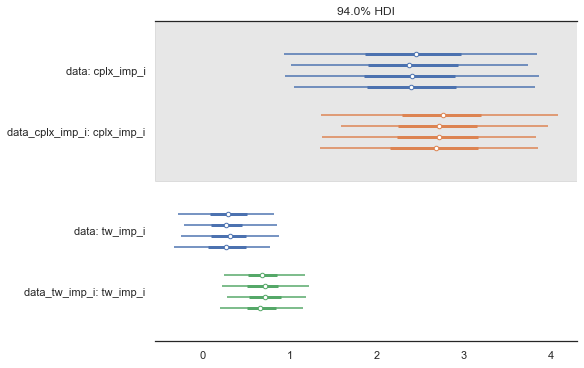

In [91]:
az.plot_forest([indiv_traces['data'], indiv_traces['data_cplx_imp_i'], indiv_traces['data_tw_imp_i']],
               model_names=[data.name, data_cplx_imp_i.name, data_tw_imp_i.name],
               var_names=['cplx_imp_i', 'tw_imp_i'],
               combined=False, colors='cycle', figsize=(8, 5))
plt.show()